
## StyleSwin training on Trans-cerebellum plane images using pre-trained weights


**Author(s):** Zhanxiang (Sean) Sun [@seansunn](https://github.com/seansunn)

**Contributor(s):** Harvey Mannering [@harveymannering](https://github.com/harveymannering) and Miguel Xochicale [@mxochicale](https://github.com/mxochicale)


### Introduction
This notebook presents implementation of StyleSwin GAN model on the datasets for this project.

### Running notebook
Go to repository path: `cd $HOME/repositories/budai4medtech/xfetus/notebooks`   
Open repo in pycharm and in the terminal type:
```
git checkout master # or the branch
git pull # to bring a local branch up-to-date with its remote version
```
Launch Notebook server:
```
conda activate febusisVE
jupyter notebook --browser=firefox
```
which will open your web-browser.


### Logbook
* [DATE]: Short description of the update


### References

Bowen Zhang, Shuyang Gu, Bo Zhang, Jianmin Bao, Dong Chen, Fang Wen, Yong Wang, and Baining Guo. Styleswin: Transformer-based gan for high-resolution image generation. In *Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)*, pages 11304–11314, June 2022.<br>
Official implementation: https://github.com/microsoft/StyleSwin<br>

Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han. Differentiable Augmentation for Data-Efficient GAN Training, June 2020.<br>
Official implementation: https://github.com/mit-han-lab/data-efficient-gans<br>

Liming Jiang, Bo Dai, Wayne Wu, and Chen Change Loy. Deceive D: Adaptive Pseudo Augmentation for GAN Training with Limited Data, 2021.<br>
Official implementation: https://github.com/EndlessSora/DeceiveD<br>





## 0. Setting imports and datasets paths


In [1]:
%load_ext autoreload
%autoreload 2
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance

from xfetus.styleswingan.dataset import getDataset, denormalize
from xfetus.styleswingan.diffaug import DiffAugment
from xfetus.styleswingan.generator import Generator
from xfetus.styleswingan.discriminator import Discriminator


HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]

REPOSITORY_PATH='repositories/datasets/FETAL_PLANES_ZENODO/'
FULL_REPO_DATA_PATH = HOME_PATH+'/'+REPOSITORY_PATH

# Root directory for dataset
dataroot = FULL_REPO_DATA_PATH + "Images/"
ref = FULL_REPO_DATA_PATH + "FETAL_PLANES_DB_data.csv"


%matplotlib inline
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint_path = 'data/saved_tc_256/'



## 1. Load datasets


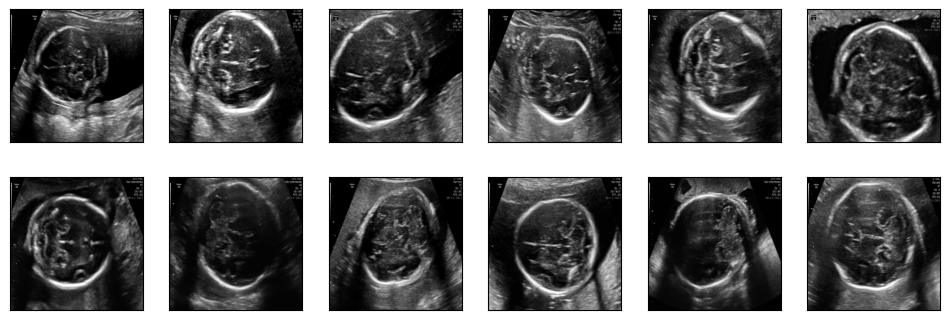

<Figure size 640x480 with 0 Axes>

In [2]:
# ['Trans-thalamic', 'Trans-cerebellum', 'Trans-ventricular']
brain_plane = 'Trans-cerebellum'
training_data = getDataset(brain_plane, data_path='repositories/datasets/FETAL_PLANES_ZENODO/Images/', size=256, show_img=True)


In [3]:
test_data = torch.load(f'{brain_plane}.pt', map_location=torch.device('cpu'))
test_len = len(test_data)
test_len


99


## 2. Define loss


In [4]:
def discriminator_loss(real_pred, fake_pred):
    real_loss = F.softplus(-real_pred)
    fake_loss = F.softplus(fake_pred)
    return real_loss.mean() + fake_loss.mean()


def generator_loss(fake_pred):
    return F.softplus(-fake_pred).mean()


def d_real_logits(x, model):
    return model(x)[:,0] 


def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag



## 3. Initialize parameters for DiffAug and APA


In [5]:
# Diffaug policy
policy = "flip,color,translation"

# APA parameters
APA_p = 0.05
APA_max_prob = 0.3
APA_threshold = 0.95
APA_decay = 1e-5



## 4. Hyperparameters, initialization, and helper functions


In [6]:
latent_dim = 512
n_epochs = 200
batch_size = 4
accumulation_steps = 8
d_lr = 0.0002
g_lr = 0.00005
beta1 = 0.5
beta2 = 0.999
number_of_workers = 4


In [7]:
train_dataloader = DataLoader(training_data, batch_size, num_workers=number_of_workers, shuffle=True, drop_last=True)
discriminator = Discriminator().to(device)
generator = Generator().to(device)
d_optimizer = torch.optim.Adam(discriminator.parameters(), d_lr, [beta1, beta2])
g_optimizer = torch.optim.Adam(generator.parameters(), g_lr, [beta1, beta2])
scaler = torch.cuda.amp.GradScaler()


According to *Heusel et al.* ([repo](https://github.com/bioinf-jku/TTUR#fr%C3%A9chet-inception-distance-fid), [paper](https://arxiv.org/abs/1706.08500)):

*"MPORTANT: The number of samples to calculate the Gaussian statistics (mean and covariance) should be greater than the dimension of the coding layer, here 2048 for the Inception pool 3 layer. Otherwise the covariance is not full rank resulting in complex numbers and nans by calculating the square root."*

Since we only have 99 samples for evaluation, the feature size are set to 64. (The other options are: 64, 768, 2048)

In [8]:
fid = FrechetInceptionDistance(feature=64).to('cpu')


In [9]:
# load trained weights from plane Trans-thalamus

# Hi Sean
# Yes, it would be great to have checkpoints integrated at leasts in the notebooks
# Hence we can run the following lines here. Thanks, --Miguel
discriminator.load_state_dict(torch.load('data/saved_tt_256/d_500.pt'))
generator.load_state_dict(torch.load('data/saved_tt_256/g_500.pt'))


<All keys matched successfully>

In [10]:
def display(generated_images):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(6, 4))
    plot_size = 3
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(1, int(plot_size), idx+1, xticks=[], yticks=[])
        img = denormalize(generated_images[idx]).squeeze().detach().cpu().numpy()
        ax.imshow(img, cmap='gray')
    plt.show()
    plt.clf()


def expand_channel(x):
    # repeats channel for 3 times
    return x.repeat(1, 3, 1, 1)



## 5. Train the model


Epoch [  1/200] | D loss:  1.09 | G loss:  1.09 | P(apa): 0.16
Epoch [  2/200] | D loss:  1.08 | G loss:  1.14 | P(apa): 0.28
Epoch [  3/200] | D loss:  1.11 | G loss:  1.14 | P(apa): 0.29
Epoch [  4/200] | D loss:  1.06 | G loss:  1.14 | P(apa): 0.29
Epoch [  5/200] | D loss:  1.08 | G loss:  1.10 | P(apa): 0.29
Epoch [  6/200] | D loss:  1.08 | G loss:  1.15 | P(apa): 0.29
Epoch [  7/200] | D loss:  1.09 | G loss:  1.18 | P(apa): 0.29
Epoch [  8/200] | D loss:  1.12 | G loss:  1.04 | P(apa): 0.29
Epoch [  9/200] | D loss:  1.19 | G loss:  1.07 | P(apa): 0.29
Epoch [ 10/200] | D loss:  1.17 | G loss:  1.19 | P(apa): 0.29
Check point saved; FID: 29.22


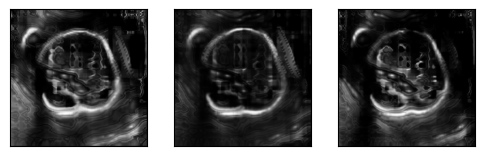

Epoch [ 11/200] | D loss:  1.08 | G loss:  1.15 | P(apa): 0.29
Epoch [ 12/200] | D loss:  1.05 | G loss:  1.11 | P(apa): 0.28
Epoch [ 13/200] | D loss:  1.03 | G loss:  1.19 | P(apa): 0.28
Epoch [ 14/200] | D loss:  1.04 | G loss:  1.07 | P(apa): 0.29
Epoch [ 15/200] | D loss:  1.10 | G loss:  1.13 | P(apa): 0.29
Epoch [ 16/200] | D loss:  1.23 | G loss:  1.05 | P(apa): 0.29
Epoch [ 17/200] | D loss:  1.12 | G loss:  1.01 | P(apa): 0.29
Epoch [ 18/200] | D loss:  1.20 | G loss:  1.05 | P(apa): 0.29
Epoch [ 19/200] | D loss:  1.07 | G loss:  1.09 | P(apa): 0.29
Epoch [ 20/200] | D loss:  1.12 | G loss:  1.07 | P(apa): 0.29
Check point saved; FID: 30.67


<Figure size 640x480 with 0 Axes>

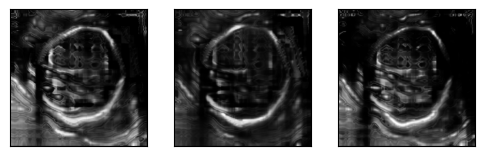

Epoch [ 21/200] | D loss:  1.06 | G loss:  1.14 | P(apa): 0.27
Epoch [ 22/200] | D loss:  1.15 | G loss:  1.05 | P(apa): 0.28
Epoch [ 23/200] | D loss:  1.13 | G loss:  1.11 | P(apa): 0.28
Epoch [ 24/200] | D loss:  1.09 | G loss:  1.03 | P(apa): 0.29
Epoch [ 25/200] | D loss:  1.23 | G loss:  1.09 | P(apa): 0.29
Epoch [ 26/200] | D loss:  1.06 | G loss:  1.04 | P(apa): 0.29
Epoch [ 27/200] | D loss:  1.16 | G loss:  1.05 | P(apa): 0.29
Epoch [ 28/200] | D loss:  1.14 | G loss:  1.06 | P(apa): 0.29
Epoch [ 29/200] | D loss:  1.23 | G loss:  1.11 | P(apa): 0.29
Epoch [ 30/200] | D loss:  1.16 | G loss:  0.95 | P(apa): 0.29
Check point saved; FID: 31.18


<Figure size 640x480 with 0 Axes>

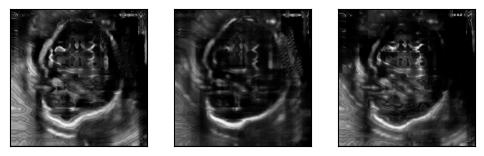

Epoch [ 31/200] | D loss:  1.15 | G loss:  0.98 | P(apa): 0.29
Epoch [ 32/200] | D loss:  1.15 | G loss:  1.03 | P(apa): 0.29
Epoch [ 33/200] | D loss:  1.19 | G loss:  1.02 | P(apa): 0.29
Epoch [ 34/200] | D loss:  1.08 | G loss:  1.13 | P(apa): 0.29
Epoch [ 35/200] | D loss:  1.13 | G loss:  1.07 | P(apa): 0.29
Epoch [ 36/200] | D loss:  1.19 | G loss:  1.02 | P(apa): 0.29
Epoch [ 37/200] | D loss:  1.14 | G loss:  0.98 | P(apa): 0.29
Epoch [ 38/200] | D loss:  1.14 | G loss:  1.00 | P(apa): 0.29
Epoch [ 39/200] | D loss:  1.11 | G loss:  1.00 | P(apa): 0.29
Epoch [ 40/200] | D loss:  1.13 | G loss:  1.07 | P(apa): 0.29
Check point saved; FID: 30.79


<Figure size 640x480 with 0 Axes>

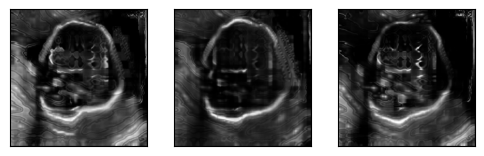

Epoch [ 41/200] | D loss:  1.13 | G loss:  1.06 | P(apa): 0.29
Epoch [ 42/200] | D loss:  1.09 | G loss:  1.07 | P(apa): 0.29
Epoch [ 43/200] | D loss:  1.15 | G loss:  1.03 | P(apa): 0.29
Epoch [ 44/200] | D loss:  1.10 | G loss:  1.16 | P(apa): 0.29
Epoch [ 45/200] | D loss:  1.13 | G loss:  1.08 | P(apa): 0.29
Epoch [ 46/200] | D loss:  1.06 | G loss:  1.06 | P(apa): 0.29
Epoch [ 47/200] | D loss:  1.15 | G loss:  1.02 | P(apa): 0.29
Epoch [ 48/200] | D loss:  1.18 | G loss:  1.05 | P(apa): 0.29
Epoch [ 49/200] | D loss:  1.20 | G loss:  1.05 | P(apa): 0.29
Epoch [ 50/200] | D loss:  1.06 | G loss:  1.06 | P(apa): 0.29
Check point saved; FID: 32.92


<Figure size 640x480 with 0 Axes>

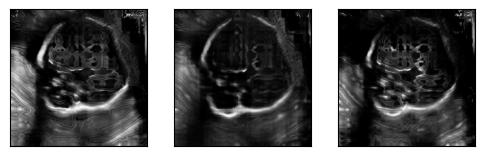

Epoch [ 51/200] | D loss:  1.15 | G loss:  1.13 | P(apa): 0.29
Epoch [ 52/200] | D loss:  1.07 | G loss:  1.09 | P(apa): 0.29
Epoch [ 53/200] | D loss:  1.18 | G loss:  1.09 | P(apa): 0.29
Epoch [ 54/200] | D loss:  1.20 | G loss:  1.19 | P(apa): 0.30
Epoch [ 55/200] | D loss:  1.15 | G loss:  1.00 | P(apa): 0.28
Epoch [ 56/200] | D loss:  1.14 | G loss:  1.05 | P(apa): 0.29
Epoch [ 57/200] | D loss:  1.09 | G loss:  1.02 | P(apa): 0.29
Epoch [ 58/200] | D loss:  1.08 | G loss:  1.07 | P(apa): 0.29
Epoch [ 59/200] | D loss:  1.10 | G loss:  1.09 | P(apa): 0.29
Epoch [ 60/200] | D loss:  1.11 | G loss:  1.05 | P(apa): 0.29
Check point saved; FID: 27.86


<Figure size 640x480 with 0 Axes>

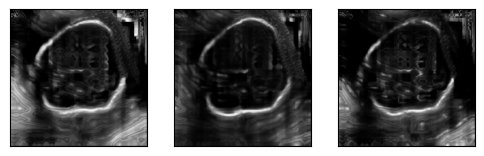

Epoch [ 61/200] | D loss:  1.04 | G loss:  1.10 | P(apa): 0.29
Epoch [ 62/200] | D loss:  1.11 | G loss:  1.14 | P(apa): 0.29
Epoch [ 63/200] | D loss:  1.22 | G loss:  1.00 | P(apa): 0.29
Epoch [ 64/200] | D loss:  1.06 | G loss:  1.10 | P(apa): 0.29
Epoch [ 65/200] | D loss:  1.21 | G loss:  1.12 | P(apa): 0.28
Epoch [ 66/200] | D loss:  1.11 | G loss:  1.02 | P(apa): 0.29
Epoch [ 67/200] | D loss:  1.08 | G loss:  1.06 | P(apa): 0.29
Epoch [ 68/200] | D loss:  1.12 | G loss:  1.06 | P(apa): 0.29
Epoch [ 69/200] | D loss:  1.11 | G loss:  1.11 | P(apa): 0.29
Epoch [ 70/200] | D loss:  1.19 | G loss:  1.03 | P(apa): 0.29
Check point saved; FID: 37.19


<Figure size 640x480 with 0 Axes>

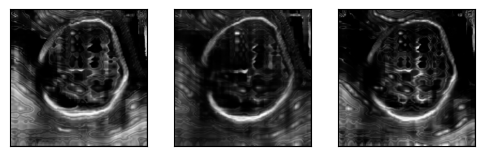

Epoch [ 71/200] | D loss:  1.16 | G loss:  1.06 | P(apa): 0.29
Epoch [ 72/200] | D loss:  1.11 | G loss:  1.14 | P(apa): 0.29
Epoch [ 73/200] | D loss:  1.15 | G loss:  1.00 | P(apa): 0.29
Epoch [ 74/200] | D loss:  1.13 | G loss:  1.06 | P(apa): 0.30
Epoch [ 75/200] | D loss:  1.07 | G loss:  1.07 | P(apa): 0.28
Epoch [ 76/200] | D loss:  1.09 | G loss:  1.12 | P(apa): 0.29
Epoch [ 77/200] | D loss:  1.07 | G loss:  1.11 | P(apa): 0.29
Epoch [ 78/200] | D loss:  1.15 | G loss:  1.12 | P(apa): 0.29
Epoch [ 79/200] | D loss:  1.15 | G loss:  1.04 | P(apa): 0.29
Epoch [ 80/200] | D loss:  1.22 | G loss:  1.05 | P(apa): 0.29
Check point saved; FID: 31.47


<Figure size 640x480 with 0 Axes>

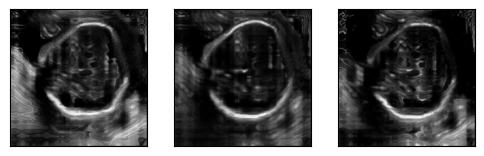

Epoch [ 81/200] | D loss:  1.13 | G loss:  0.97 | P(apa): 0.29
Epoch [ 82/200] | D loss:  1.13 | G loss:  0.98 | P(apa): 0.29
Epoch [ 83/200] | D loss:  1.15 | G loss:  1.07 | P(apa): 0.29
Epoch [ 84/200] | D loss:  1.13 | G loss:  0.98 | P(apa): 0.29
Epoch [ 85/200] | D loss:  1.08 | G loss:  1.04 | P(apa): 0.29
Epoch [ 86/200] | D loss:  1.10 | G loss:  1.04 | P(apa): 0.29
Epoch [ 87/200] | D loss:  1.28 | G loss:  1.11 | P(apa): 0.29
Epoch [ 88/200] | D loss:  1.10 | G loss:  1.02 | P(apa): 0.29
Epoch [ 89/200] | D loss:  1.11 | G loss:  1.07 | P(apa): 0.29
Epoch [ 90/200] | D loss:  1.13 | G loss:  1.10 | P(apa): 0.29
Check point saved; FID: 30.83


<Figure size 640x480 with 0 Axes>

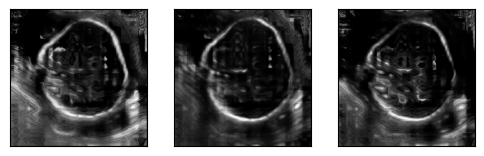

Epoch [ 91/200] | D loss:  1.08 | G loss:  1.04 | P(apa): 0.28
Epoch [ 92/200] | D loss:  1.12 | G loss:  0.99 | P(apa): 0.29
Epoch [ 93/200] | D loss:  1.12 | G loss:  1.08 | P(apa): 0.29
Epoch [ 94/200] | D loss:  1.03 | G loss:  1.09 | P(apa): 0.28
Epoch [ 95/200] | D loss:  1.21 | G loss:  1.06 | P(apa): 0.28
Epoch [ 96/200] | D loss:  1.12 | G loss:  1.13 | P(apa): 0.29
Epoch [ 97/200] | D loss:  1.02 | G loss:  1.10 | P(apa): 0.29
Epoch [ 98/200] | D loss:  1.04 | G loss:  1.20 | P(apa): 0.27
Epoch [ 99/200] | D loss:  1.12 | G loss:  1.13 | P(apa): 0.28
Epoch [100/200] | D loss:  1.08 | G loss:  1.12 | P(apa): 0.29
Check point saved; FID: 37.44


<Figure size 640x480 with 0 Axes>

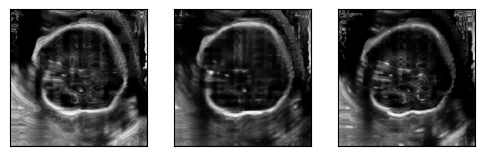

Epoch [101/200] | D loss:  1.08 | G loss:  1.10 | P(apa): 0.29
Epoch [102/200] | D loss:  1.02 | G loss:  1.16 | P(apa): 0.29
Epoch [103/200] | D loss:  1.09 | G loss:  1.11 | P(apa): 0.28
Epoch [104/200] | D loss:  1.18 | G loss:  1.27 | P(apa): 0.29
Epoch [105/200] | D loss:  1.11 | G loss:  1.12 | P(apa): 0.28
Epoch [106/200] | D loss:  1.03 | G loss:  1.14 | P(apa): 0.28
Epoch [107/200] | D loss:  1.12 | G loss:  1.16 | P(apa): 0.29
Epoch [108/200] | D loss:  1.11 | G loss:  1.12 | P(apa): 0.29
Epoch [109/200] | D loss:  1.13 | G loss:  1.03 | P(apa): 0.29
Epoch [110/200] | D loss:  1.14 | G loss:  1.02 | P(apa): 0.29
Check point saved; FID: 31.78


<Figure size 640x480 with 0 Axes>

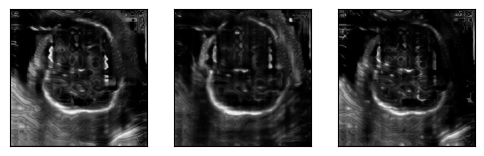

Epoch [111/200] | D loss:  1.03 | G loss:  1.05 | P(apa): 0.29
Epoch [112/200] | D loss:  1.08 | G loss:  1.10 | P(apa): 0.28
Epoch [113/200] | D loss:  1.03 | G loss:  1.16 | P(apa): 0.29
Epoch [114/200] | D loss:  1.10 | G loss:  1.17 | P(apa): 0.29
Epoch [115/200] | D loss:  1.08 | G loss:  1.12 | P(apa): 0.28
Epoch [116/200] | D loss:  1.09 | G loss:  1.10 | P(apa): 0.29
Epoch [117/200] | D loss:  1.06 | G loss:  1.21 | P(apa): 0.29
Epoch [118/200] | D loss:  1.10 | G loss:  1.16 | P(apa): 0.29
Epoch [119/200] | D loss:  1.16 | G loss:  1.11 | P(apa): 0.29
Epoch [120/200] | D loss:  1.06 | G loss:  1.12 | P(apa): 0.29
Check point saved; FID: 27.71


<Figure size 640x480 with 0 Axes>

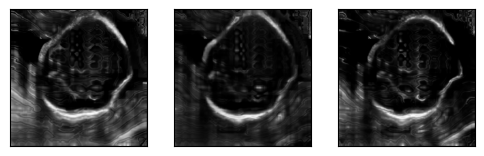

Epoch [121/200] | D loss:  1.09 | G loss:  1.11 | P(apa): 0.29
Epoch [122/200] | D loss:  1.07 | G loss:  1.14 | P(apa): 0.29
Epoch [123/200] | D loss:  1.04 | G loss:  1.18 | P(apa): 0.29
Epoch [124/200] | D loss:  1.03 | G loss:  1.22 | P(apa): 0.28
Epoch [125/200] | D loss:  1.11 | G loss:  1.16 | P(apa): 0.29
Epoch [126/200] | D loss:  1.03 | G loss:  1.15 | P(apa): 0.28
Epoch [127/200] | D loss:  1.13 | G loss:  1.06 | P(apa): 0.29
Epoch [128/200] | D loss:  1.08 | G loss:  1.16 | P(apa): 0.29
Epoch [129/200] | D loss:  1.10 | G loss:  1.13 | P(apa): 0.29
Epoch [130/200] | D loss:  1.10 | G loss:  1.11 | P(apa): 0.28
Check point saved; FID: 37.09


<Figure size 640x480 with 0 Axes>

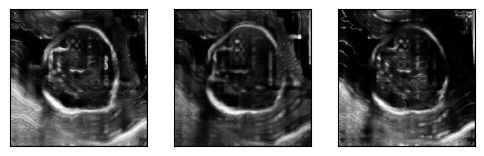

Epoch [131/200] | D loss:  1.09 | G loss:  1.13 | P(apa): 0.29
Epoch [132/200] | D loss:  1.04 | G loss:  1.07 | P(apa): 0.29
Epoch [133/200] | D loss:  1.10 | G loss:  1.13 | P(apa): 0.29
Epoch [134/200] | D loss:  1.03 | G loss:  1.13 | P(apa): 0.28
Epoch [135/200] | D loss:  1.13 | G loss:  1.10 | P(apa): 0.28
Epoch [136/200] | D loss:  1.01 | G loss:  1.11 | P(apa): 0.28
Epoch [137/200] | D loss:  1.12 | G loss:  1.17 | P(apa): 0.29
Epoch [138/200] | D loss:  1.03 | G loss:  1.14 | P(apa): 0.29
Epoch [139/200] | D loss:  1.40 | G loss:  1.14 | P(apa): 0.29
Epoch [140/200] | D loss:  1.08 | G loss:  1.07 | P(apa): 0.29
Check point saved; FID: 38.40


<Figure size 640x480 with 0 Axes>

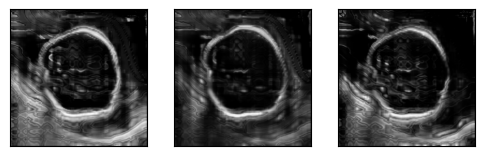

Epoch [141/200] | D loss:  1.09 | G loss:  1.01 | P(apa): 0.29
Epoch [142/200] | D loss:  1.12 | G loss:  1.07 | P(apa): 0.29
Epoch [143/200] | D loss:  1.12 | G loss:  1.12 | P(apa): 0.29
Epoch [144/200] | D loss:  1.05 | G loss:  1.08 | P(apa): 0.29
Epoch [145/200] | D loss:  1.07 | G loss:  1.08 | P(apa): 0.29
Epoch [146/200] | D loss:  1.19 | G loss:  1.10 | P(apa): 0.29
Epoch [147/200] | D loss:  1.10 | G loss:  1.08 | P(apa): 0.29
Epoch [148/200] | D loss:  1.10 | G loss:  1.10 | P(apa): 0.29
Epoch [149/200] | D loss:  1.22 | G loss:  1.00 | P(apa): 0.29
Epoch [150/200] | D loss:  1.14 | G loss:  1.09 | P(apa): 0.29
Check point saved; FID: 35.92


<Figure size 640x480 with 0 Axes>

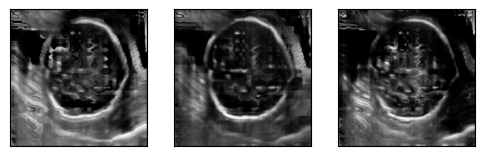

Epoch [151/200] | D loss:  1.14 | G loss:  0.96 | P(apa): 0.29
Epoch [152/200] | D loss:  1.09 | G loss:  1.08 | P(apa): 0.28
Epoch [153/200] | D loss:  1.12 | G loss:  1.00 | P(apa): 0.29
Epoch [154/200] | D loss:  1.08 | G loss:  1.08 | P(apa): 0.29
Epoch [155/200] | D loss:  1.01 | G loss:  1.12 | P(apa): 0.28
Epoch [156/200] | D loss:  1.20 | G loss:  1.10 | P(apa): 0.29
Epoch [157/200] | D loss:  1.16 | G loss:  1.07 | P(apa): 0.29
Epoch [158/200] | D loss:  1.09 | G loss:  1.09 | P(apa): 0.29
Epoch [159/200] | D loss:  1.12 | G loss:  1.06 | P(apa): 0.28
Epoch [160/200] | D loss:  1.04 | G loss:  1.12 | P(apa): 0.28
Check point saved; FID: 32.57


<Figure size 640x480 with 0 Axes>

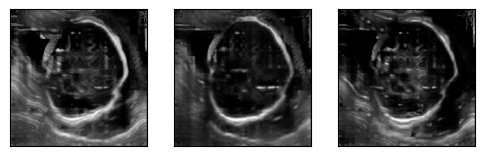

Epoch [161/200] | D loss:  1.08 | G loss:  1.08 | P(apa): 0.29
Epoch [162/200] | D loss:  1.12 | G loss:  1.10 | P(apa): 0.28
Epoch [163/200] | D loss:  1.09 | G loss:  1.10 | P(apa): 0.29
Epoch [164/200] | D loss:  1.13 | G loss:  1.09 | P(apa): 0.29
Epoch [165/200] | D loss:  1.14 | G loss:  1.04 | P(apa): 0.29
Epoch [166/200] | D loss:  1.02 | G loss:  1.15 | P(apa): 0.28
Epoch [167/200] | D loss:  1.04 | G loss:  1.07 | P(apa): 0.29
Epoch [168/200] | D loss:  1.12 | G loss:  1.13 | P(apa): 0.29
Epoch [169/200] | D loss:  1.18 | G loss:  1.05 | P(apa): 0.29
Epoch [170/200] | D loss:  1.11 | G loss:  1.07 | P(apa): 0.29
Check point saved; FID: 29.38


<Figure size 640x480 with 0 Axes>

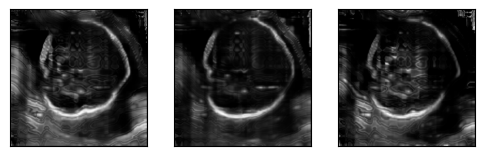

Epoch [171/200] | D loss:  1.07 | G loss:  1.04 | P(apa): 0.29
Epoch [172/200] | D loss:  1.11 | G loss:  1.01 | P(apa): 0.28
Epoch [173/200] | D loss:  1.17 | G loss:  1.11 | P(apa): 0.29
Epoch [174/200] | D loss:  1.05 | G loss:  1.16 | P(apa): 0.29
Epoch [175/200] | D loss:  1.08 | G loss:  1.04 | P(apa): 0.28
Epoch [176/200] | D loss:  1.10 | G loss:  1.09 | P(apa): 0.29
Epoch [177/200] | D loss:  1.09 | G loss:  1.12 | P(apa): 0.29
Epoch [178/200] | D loss:  1.06 | G loss:  1.13 | P(apa): 0.28
Epoch [179/200] | D loss:  1.00 | G loss:  1.13 | P(apa): 0.28
Epoch [180/200] | D loss:  1.14 | G loss:  1.13 | P(apa): 0.29
Check point saved; FID: 27.97


<Figure size 640x480 with 0 Axes>

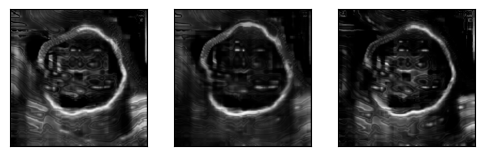

Epoch [181/200] | D loss:  1.04 | G loss:  1.11 | P(apa): 0.29
Epoch [182/200] | D loss:  1.01 | G loss:  1.24 | P(apa): 0.26
Epoch [183/200] | D loss:  1.04 | G loss:  1.17 | P(apa): 0.28
Epoch [184/200] | D loss:  1.13 | G loss:  1.17 | P(apa): 0.28
Epoch [185/200] | D loss:  1.08 | G loss:  1.16 | P(apa): 0.27
Epoch [186/200] | D loss:  1.11 | G loss:  1.07 | P(apa): 0.29
Epoch [187/200] | D loss:  1.06 | G loss:  1.16 | P(apa): 0.29
Epoch [188/200] | D loss:  1.11 | G loss:  1.05 | P(apa): 0.29
Epoch [189/200] | D loss:  1.12 | G loss:  1.04 | P(apa): 0.29
Epoch [190/200] | D loss:  1.11 | G loss:  1.06 | P(apa): 0.29
Check point saved; FID: 33.01


<Figure size 640x480 with 0 Axes>

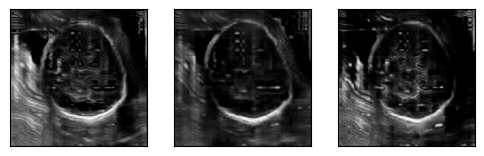

Epoch [191/200] | D loss:  1.13 | G loss:  1.04 | P(apa): 0.29
Epoch [192/200] | D loss:  1.15 | G loss:  1.08 | P(apa): 0.29
Epoch [193/200] | D loss:  1.04 | G loss:  1.06 | P(apa): 0.28
Epoch [194/200] | D loss:  1.10 | G loss:  1.13 | P(apa): 0.29
Epoch [195/200] | D loss:  1.09 | G loss:  1.12 | P(apa): 0.28
Epoch [196/200] | D loss:  1.14 | G loss:  1.10 | P(apa): 0.28
Epoch [197/200] | D loss:  1.06 | G loss:  1.10 | P(apa): 0.29
Epoch [198/200] | D loss:  1.09 | G loss:  1.26 | P(apa): 0.29
Epoch [199/200] | D loss:  1.11 | G loss:  1.01 | P(apa): 0.29
Epoch [200/200] | D loss:  1.10 | G loss:  1.12 | P(apa): 0.28
Check point saved; FID: 34.47


<Figure size 640x480 with 0 Axes>

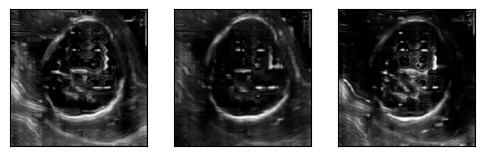

<Figure size 640x480 with 0 Axes>

In [11]:
fixed_latent_vector = torch.randn(3, latent_dim).float().to(device)
fixed_FID_vector = torch.randn(test_len, latent_dim).float().to(device)

losses = []
fids = []

discriminator.train()
generator.train()

for epoch in range(n_epochs):

    g_losses = []
    d_losses = []
    p_apas = []
    
    for i, real_images in enumerate(train_dataloader):
        
        real_images = real_images.to(device)
        z = torch.randn(batch_size, latent_dim).float().requires_grad_(False).to(device)
        
        # Discriminator step
        generator.train()
        requires_grad(generator, False)
        requires_grad(discriminator, True)

        # Gradient accumulation
        if i % accumulation_steps == 0:
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()

        with torch.autocast(device_type='cuda', dtype=torch.float16):

            # DiffAug for both real and fake images
            real_images = DiffAugment(real_images, policy=policy)
            fake_images = DiffAugment(generator(z), policy=policy).detach().to(device)
            
            with torch.no_grad():
                
                # APA implementation
                
                # (1) Update APA_p
                lambda_r = d_real_logits(real_images, discriminator).sign().mean()
                APA_p = 0.99 * APA_p + 0.01 * (APA_threshold - lambda_r)
                if lambda_r < APA_threshold and APA_p < APA_max_prob:
                    APA_p += 0.01 * (APA_threshold - lambda_r)
                elif lambda_r > APA_threshold and APA_p > 0:
                    APA_p -= 0.01 * (lambda_r - APA_threshold)
                APA_p = max(0, min(APA_p, APA_max_prob))
                APA_p = APA_p - APA_decay
                p_apas.append(APA_p)

                # (2) Add fake images into real images
                probs = APA_p * torch.ones(batch_size).to(device)
                counts = torch.ones(batch_size).to(device)
                num_mix_fakes = int(torch.binomial(counts, probs).sum())
                mix_idx = torch.randperm(batch_size)[:num_mix_fakes]
                real_images[mix_idx] = fake_images[mix_idx]

            # Discriminator loss
            d_real = discriminator(real_images)
            d_fake = discriminator(fake_images)
            d_loss = discriminator_loss(d_real, d_fake)

            del fake_images
            scaler.scale(d_loss).backward()
            d_losses.append(d_loss.item())

        # Generator step
        g_optimizer.zero_grad()
        requires_grad(generator, True)
        requires_grad(discriminator, False)
        with torch.autocast(device_type='cuda', dtype=torch.float16):

            # DiffAug
            fake_images = DiffAugment(generator(z), policy=policy)
            d_fake = discriminator(fake_images)
            g_loss = generator_loss(d_fake)

            del fake_images
            scaler.scale(g_loss).backward()
            g_losses.append(g_loss.item())

        # Update optimizers
        if (i+1) % accumulation_steps == 0:
            scaler.step(d_optimizer)
            scaler.step(g_optimizer)
            scaler.update()

    # Update the optimizers if last steps < accumulation_steps
    if (i+1) % accumulation_steps != 0:
        scaler.step(d_optimizer)
        scaler.step(g_optimizer)
        scaler.update()
    
    g_losses = sum(g_losses) / len(g_losses)
    d_losses = sum(d_losses) / len(d_losses)
    p_apas = sum(p_apas) / len(p_apas)
    losses.append((d_losses, g_losses))

    print(f'Epoch [{epoch+1:3}/{n_epochs}] | D loss: {d_losses:5.2f} | G loss: {g_losses:5.2f} | P(apa): {p_apas:.2f}')

    # Checkpoints and visualizations
    if (epoch+1) % 10 == 0:
        generator.eval()
        with torch.no_grad():
            fid_img_list = []
            for i in range(test_len):
                fid_img = denormalize(generator(fixed_FID_vector[i].unsqueeze(0))).detach().cpu()
                fid_img_list.append(fid_img)

            fid_cat = torch.cat(fid_img_list)
            fid.update(test_data, real=True)
            fid.update(expand_channel(fid_cat), real=False)
            current_fid = fid.compute().item()
            fids.append(current_fid)
            fid.reset()

            # Save checpoint
            torch.save(discriminator.state_dict(), checkpoint_path+f'd_{epoch+1:03}.pt')
            torch.save(generator.state_dict(), checkpoint_path+f'g_{epoch+1:03}.pt')
            print(f'Check point saved; FID: {current_fid:.2f}')
            
            # Display images during training
            generated_images = generator(fixed_latent_vector)
            display(generated_images)
            del generated_images



## 6. Plot losses and FIDs



### 6.1 Training losses


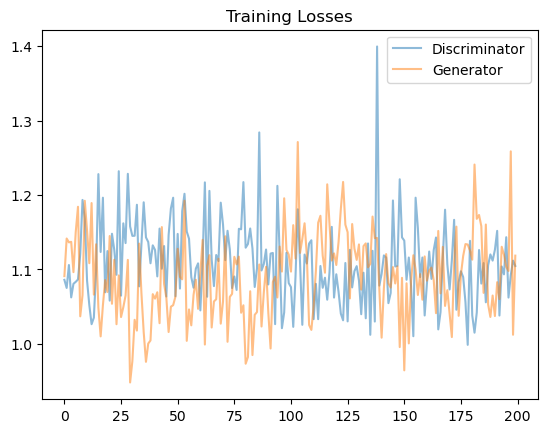

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()



### 6.2 FIDs


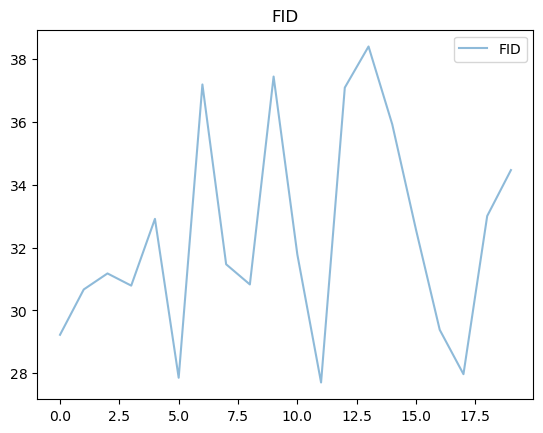

In [13]:
fig, ax = plt.subplots()
plt.plot(fids, label='FID', alpha=0.5)
plt.title("FID")
plt.legend()



### 6.3 Export logs


In [14]:
import numpy as np


D_loss_log = losses.T[0]
G_loss_log = losses.T[1]
fid_log = np.array(fids)
np.save('logs/tc_200_2_D_loss_log.npy', D_loss_log)
np.save('logs/tc_200_2_G_loss_log.npy', G_loss_log)
np.save('logs/tc_200_2_FID_log.npy', fid_log)
